# 1a

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})

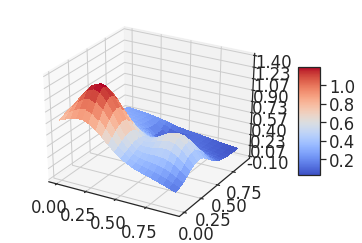

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

numberOfObservations = len(x)
xPlot, yPlot = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(xPlot, yPlot)

# Plot the surface.
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [18]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree):
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        self.degree = degree
        self.numberOfObservations = len(self.x)
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        XHat = np.c_[x, y]
        polynomialDegree = self.degree
        poly = PolynomialFeatures(polynomialDegree)
        self.XHat = poly.fit_transform(XHat)
        return self.XHat

    def estimate(self):
        XHat = self.XHat
        self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        return self.betaHat
        
    def fit(self):
        XHat = self.XHat
        betaHat = self.betaHat
        self.zFit = XHat.dot(betaHat)
        return self.zFit
    
    def predict(self):
        XHat = self.XHat
        betaHat = self.betaHat
        self.zPredict = XHat.dot(betaHat)
        return self.zPredict
        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = np.reshape(zPredict, np.shape(zPlot))    

        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot/zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        ax.set_zlim(-1.50, 25.0)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predict/True')
        plt.show()
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict= self.z, self.zPredict
        mse = mean_squared_error(z, zPredict)
        r2 = r2_score(z, zPredict)
        print("Mean squared error: %.4f" % mse)
        print('R2 score: %.4f' % r2)
        return mse, r2

    def calculateVarianceBeta(self):
        lambdaRidge = 0
        XHat = self.XHat
        betaHat = self.betaHat
        x, z = self.x, self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        yFitted = XHat.dot(betaHat)
        predictionError2 = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(predictionError2)
        W = np.linalg.inv(XHat.T.dot(XHat) + lambdaRidge*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        #return varBeta
        
    
    def errorBootstrap(self, numberOfCrossTests=2): 
        mseBootstrap = 0
        for iteration in range(numberOfCrossTests):
            # Training
            xTraining1D = np.random.choice(self.xOrg, len(self.xOrg))
            yTraining1D = np.random.choice(self.yOrg, len(self.yOrg))
            xTrainingIndices = np.nonzero(np.isin(self.xOrg,xTraining1D))[0]
            yTrainingIndices = np.nonzero(np.isin(self.yOrg,yTraining1D))[0]
            zTrainingPlot = self.zPlot[xTrainingIndices, yTrainingIndices]
            print('size x,y train index', np.shape(xTrainingIndices), np.shape(yTrainingIndice, \
                 np.shape(zTrainingPlot)))
            xTrainingPlot, yTrainingPlot = np.meshgrid(xTraining1D, yTraining1D)
            xTraining, yTraining = np.reshape(xTrainingPlot, -1, 1), np.reshape(yTrainingPlot, -1, 1)
            
            XHat = np.c_[xTraining, yTraining]
            polynomialDegree = self.degree
            poly = PolynomialFeatures(polynomialDegree)
            XHat = poly.fit_transform(XHat)
            betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(zTrainingPlot.reshape(-1,1))
            
            # Testing
            a = np.isin(self.xOrg, xTraining1D) # Identifying indices elements used in bootstrap
            b = np.logical_not(a>0)
            xValidationIndices = np.nonzero(b)[0]            
            a = np.isin(self.yOrg, yTraining1D)
            b = np.logical_not(a>0)
            yValidationIndices = np.nonzero(b)[0]
            
            zValidation = np.reshape(self.zPlot[xValidationIndices, yValidationIndices], -1, 1)
            
            xValidation1D, yValidation1D = self.xOrg[xValidationIndices], self.xOrg[yValidationIndices]
            xValidationPlot, yValidationPlot = np.meshgrid(xValidation1D, yValidation1D)
            xValidation, yValidation = np.reshape(xValidationPlot, -1, 1), np.reshape(yValidationPlot, -1, 1)
            
            XHat = np.c_[xValidation, yValidation]
            XHat = poly.fit_transform(XHat)
            zPredict = XHat.dot(betaHat)
            
            mseBootstrap += mean_squared_error(zValidation, zPredict)
            
        self.mseBootstrap = mseBootstrap/numberOfCrossTests
          
            #HERE: issue: x and y can get idfferent dimensions dependeing on how many replacements there are. 
            # Should draw one 2d point at a time. But then we must condition on both coordinates when deciding
            # valdiation set. Example: (1,0) and (1,1). Here x = 1 in both cases, but the points are different in 2d, 
            # and so both the points should be kept.

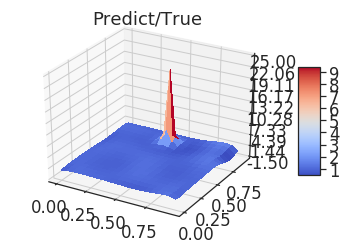

Mean squared error: 0.0022
R2 score: 0.9730


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (12,) (13,) 

In [19]:
# Testing class

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)
degree = 5
ls = LeastSquares(xPlot, yPlot, zPlot, degree)
ls.createDesignMatrix()
ls.estimate()
ls.fit()
ls.predict()
ls.plot()
ls.calculateErrorScores()
ls.calculateVarianceBeta()
ls.errorBootstrap()

The plot above shows tha there is a huge difference between the predicted and the true solution in a small area of the domain. At most the predicted solution is approximately 20 times larger than the true solution. The error scores are very good. However, looking at the figure above, we see that low error scores are no guarantee for the fit being good over the whole domain.

In [125]:
data = x
bootVec = np.zeros(len(data))

for k in range(len(x)):        
    #print(np.random.choice(data, len(data)))
    bootVec[k] = np.average(np.random.choice(data, len(data)))
#print(bootVec)

a = np.array((1,2,3,4, 5, 6,7,8,9))
b = np.array((1,1,2,4))
c = np.nonzero(np.in1d(a, b))[0]
print('c', c, 'a[c]', a[c])
d = np.nonzero(np.isin(a,b))[0]
print('d', d)
e = np.isin(a,b)
print('e', e)
#f = bindices_zero = (e == 0)
#print('f', f)
g = np.logical_not(e>0)
print('g', g)
h = np.nonzero(g)[0]
print('h', h)
i = a[h]
print('i', i)



c [0 1 3] a[c] [1 2 4]
d [0 1 3]
e [ True  True False  True False False False False False]
g [False False  True False  True  True  True  True  True]
h [2 4 5 6 7 8]
i [3 5 6 7 8 9]


In [126]:
a = np.array((1,2,3,4, 5, 6,7,8,9))
b = np.array((1,1,2,4))

d = np.nonzero(np.isin(a,b))[0]
print('d', d)
e = np.isin(a,b)
print('e', e)
#f = bindices_zero = (e == 0)
#print('f', f)
g = np.logical_not(e>0)
print('g', g)
h = np.nonzero(g)[0]
print('h', h)
i = a[h]
print('i', i)


d [0 1 3]
e [ True  True False  True False False False False False]
g [False False  True False  True  True  True  True  True]
h [2 4 5 6 7 8]
i [3 5 6 7 8 9]


In [115]:
x = np.arange(0, 1, .25)#0.05)
y = np.arange(0, 1, .25)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
xPlot2 = xPlot[0]
yPlot[:,0]
z1 = FrankeFunction(xPlot, yPlot)
print('z1', z1)

x2, y2 = np.reshape(xPlot, -1, 1),  np.reshape(yPlot, -1, 1)
z2 = FrankeFunction(x2, y2)
print('\n z2', z2)
print('\n z1 reshape', np.reshape(z1, -1, 1))
print('z1 reshape == z2', np.reshape(z1, -1, 1) == z2)

z2[[0,3]]

z1[0,0]

z1 [[0.76642059 0.81885368 0.43491424 0.25206195]
 [0.80258259 1.16528332 0.53811211 0.58935857]
 [0.48180615 0.50456938 0.32576209 0.40804792]
 [0.33952742 0.27241325 0.04371943 0.1159698 ]]

 z2 [0.76642059 0.80258259 0.48180615 0.33952742 0.81885368 1.16528332
 0.50456938 0.27241325 0.43491424 0.53811211 0.32576209 0.04371943
 0.25206195 0.58935857 0.40804792 0.1159698 ]

 z1 reshape [0.76642059 0.80258259 0.48180615 0.33952742 0.81885368 1.16528332
 0.50456938 0.27241325 0.43491424 0.53811211 0.32576209 0.04371943
 0.25206195 0.58935857 0.40804792 0.1159698 ]
z1 reshape == z2 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


0.7664205912849231

In [121]:
z1[[0, 2],[1,3]]

array([0.81885368, 0.40804792])